In [ ]:
#project Ethereum price prediction V1.1
!pip3 install ann_visualizer
!pip install graphviz
import requests
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from google.colab import drive
from ann_visualizer.visualize import ann_viz;

In [ ]:
drive.mount('/content/gdrive')
csv_name = "Ethereum_Historical_Data.csv"
df=pd.read_csv('gdrive/MyDrive/Datasets/'+csv_name)
df

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 10, 2016",11.75,11.20,11.85,11.07,0.00K,4.91%
1,"Mar 11, 2016",11.95,11.75,11.95,11.75,0.18K,1.70%
2,"Mar 12, 2016",12.92,11.95,13.45,11.95,0.83K,8.12%
3,"Mar 13, 2016",15.07,12.92,15.07,12.92,1.30K,16.64%
4,"Mar 14, 2016",12.50,15.07,15.07,11.40,92.18K,-17.05%
...,...,...,...,...,...,...,...
1885,"May 08, 2021","3,905.55","3,479.81","3,952.88","3,453.37",1.34M,12.19%
1886,"May 09, 2021","3,922.23","3,905.69","3,979.77","3,734.44",1.94M,0.43%
1887,"May 10, 2021","3,947.90","3,923.48","4,203.98","3,669.84",2.70M,0.65%
1888,"May 11, 2021","4,167.78","3,948.66","4,177.53","3,781.86",1.27M,5.57%


In [ ]:
df.isnull().sum() #agar data null dasht , namayesh bede

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

In [ ]:
#Dataset Correction
X = df.copy()
X = X.drop(columns = ['Date'])  #format Date monaseb nist , hazfesh mikonim
X = X.drop(columns = ['Change %'])  #taghirat haman gheymt hast
n_rows = X.shape[0]
#in ghesmat <<,>> virgol haye mojood dar adad haye dataset ra hazf mikonad
X['Price'] = X['Price'].str.replace(',','')
X['Open'] = X['Open'].str.replace(',','')
X['High'] = X['High'].str.replace(',','')
X['Low'] = X['Low'].str.replace(',','')

def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return str(float(x.replace('K', '')) * 1000)
        return 1000.0
    if 'M' in x:
        if len(x) > 1:
            return str(float(x.replace('M', '')) * 1000000)
        return 1000000.0

X['Vol.'] = X['Vol.'].apply(value_to_float)
#X.corr()
print(X.shape)
print(X)

(1890, 5)
        Price     Open     High      Low       Vol.
0       11.75    11.20    11.85    11.07        0.0
1       11.95    11.75    11.95    11.75      180.0
2       12.92    11.95    13.45    11.95      830.0
3       15.07    12.92    15.07    12.92     1300.0
4       12.50    15.07    15.07    11.40    92180.0
...       ...      ...      ...      ...        ...
1885  3905.55  3479.81  3952.88  3453.37  1340000.0
1886  3922.23  3905.69  3979.77  3734.44  1940000.0
1887  3947.90  3923.48  4203.98  3669.84  2700000.0
1888  4167.78  3948.66  4177.53  3781.86  1270000.0
1889  4241.19  4173.61  4366.10  4151.39  2200000.0

[1890 rows x 5 columns]


In [ ]:
train_test_ratio = 0.95
X = X.drop(columns = ['High','Low','Open','Vol.'])
training_set = X[:int(train_test_ratio*n_rows)]
test_set = X[int(train_test_ratio*n_rows):]
print("Training Set:",training_set.shape)
print(training_set.tail())
print("Testing Set: ",test_set.shape)
print(test_set.tail())

Training Set: (1795, 1)
        Price
1790  1511.36
1791  1664.34
1792  1594.00
1793  1719.20
1794  1676.63
Testing Set:  (95, 1)
        Price
1885  3905.55
1886  3922.23
1887  3947.90
1888  4167.78
1889  4241.19


In [ ]:

time_series_number = 5
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled.shape)
# Creating a data structure with k=time_series_number time-steps and 1 output
X_train = []
y_train = []
for i in range(time_series_number, int(train_test_ratio*n_rows)):
    X_train.append(training_set_scaled[i-time_series_number:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(X_train[0:5])

(1795, 1)
(1790, 5, 1)
[[[0.00294891]
  [0.00306569]
  [0.00363212]
  [0.00488759]
  [0.00338686]]

 [[0.00306569]
  [0.00363212]
  [0.00488759]
  [0.00338686]
  [0.00371387]]

 [[0.00363212]
  [0.00488759]
  [0.00338686]
  [0.00371387]
  [0.00360876]]

 [[0.00488759]
  [0.00338686]
  [0.00371387]
  [0.00360876]
  [0.00235912]]

 [[0.00338686]
  [0.00371387]
  [0.00360876]
  [0.00235912]
  [0.00235912]]]


In [ ]:
print((X_train.shape[1],1))
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer = optimizer, loss = 'mean_squared_error')
model.summary()
# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

(5, 1)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 5, 100)            40800     
_________________________________________________________________
dropout_16 (Dropout)         (None, 5, 100)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
dropout_17 (Dropout)         (None, 5, 100)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 5, 100)            80400     
_________________________________________________________________
dropout_18 (Dropout)         (None, 5, 100)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)       

In [ ]:
# Getting the predicted price
#show_train_test_ratio = 0.8
dataset_train = df.iloc[:int(n_rows*train_test_ratio), 1:2]
dataset_test = df.iloc[int(n_rows*train_test_ratio):, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
dataset_total['Price'] = dataset_total['Price'].str.replace(',','')
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_series_number:].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(time_series_number, 100):
    X_test.append(inputs[i-time_series_number:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(100, 1)
(95, 5, 1)


In [ ]:
predicted_stock_price = model.predict(X_test)
print(predicted_stock_price.shape)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

(95, 1)


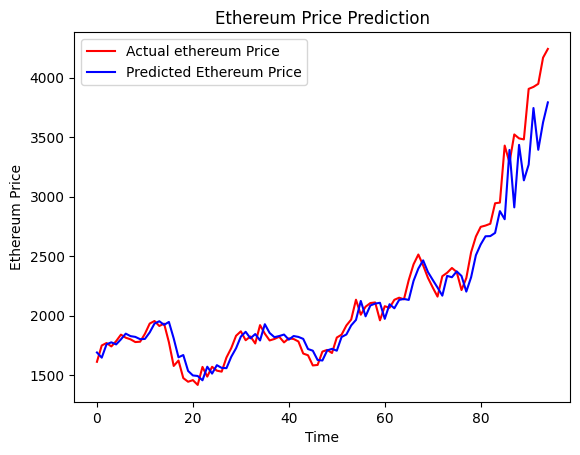

In [ ]:
# Visualising the results
#print(test_set)
plt.rcdefaults()
plt.size = (15,10)
plt.plot(range(0,95),test_set.astype(float) , color = 'red', label = 'Actual ethereum Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Ethereum Price')
plt.title('Ethereum Price Prediction')
plt.xlabel('Time')
plt.ylabel('Ethereum Price')
plt.legend()
plt.show()